# Atividade Computacional #3 - Escoamento 1D em Bocal

**Disciplina:** PMT07 - Transferência de Calor e Mecânica dos Fluidos Computacional

**Alunos:** Abner Vieira Pereira e João Gabriel Clarindo

**Assunto:** Solução do Problema 6.5 (Patankar, 1980) - Algoritmos SIMPLE, SIMPLEC e SIMPLER.



In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image


---

# 1. Enunciado

O problema consiste em resolver o campo de escoamento (velocidade e pressão) em um bocal 1D convergente. O escoamento é considerado permanente e a densidade é constante ($\rho = 1$). O domínio é discretizado utilizando uma malha desencontrada (*staggered grid*).

### Geometria e Dados
* **Domínio:** Três nós de pressão (1, 2, 3) e duas interfaces de velocidade (A, B).
* **Áreas:** $A_A = 3.0$, $A_B = 1.0$.
* **Condições de Contorno (Pressão):** $p_1 = 28$, $p_3 = 0$.
* **Valores Iniciais (Chute):** $u_A = 5/3$, $u_B = 5$, $p_2 = 25$.

### Equações Governantes
Para um escoamento 1D invíscido (sem termo difusivo), as equações são:

1.  **Continuidade:**
    $$\frac{d}{dx}(\rho u A) = 0$$
2.  **Momentum:**
    $$\frac{d}{dx}(\rho u A u) = -A \frac{dp}{dx}$$

---

In [47]:
def draw_staggered_cv(target_cv='A'):
    """
    Gera um diagrama do volume de controle para uA ou uB.
    target_cv: 'A' para o VC de uA, 'B' para o VC de uB.
    """
    
    # Configuração da Figura
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Coordenadas (Arbitrárias para visualização)
    # Nós de Pressão (P): 1, 3, 5
    # Interfaces de Velocidade (u): 2, 4
    x_nodes = [1, 3, 5]  # P1, P2, P3
    x_faces = [2, 4]     # A, B
    y_center = 0.5
    
    # Limites do gráfico
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 1)
    ax.axis('off') # Desliga eixos para ficar limpo
    
    # 1. Desenhar a Linha Principal do Domínio
    ax.plot([0.5, 5.5], [y_center, y_center], color='black', linewidth=1, zorder=1)
    
    # 2. Desenhar os Nós de Pressão (Círculos)
    # Nós principais
    ax.scatter(x_nodes, [y_center]*3, color='blue', s=100, label='Nós de Pressão (Scalar)', zorder=3)
    
    # Labels dos Nós (P1, P2, P3)
    labels_p = ['1 (P1)', '2 (P2)', '3 (P3)']
    for x, lbl in zip(x_nodes, labels_p):
        ax.text(x, y_center - 0.15, lbl, ha='center', va='top', color='blue', fontsize=12, fontweight='bold')

    # 3. Definir e Desenhar o Volume de Controle Específico
    if target_cv == 'A':
        # VC para uA vai do Nó 1 ao Nó 2
        x_start, x_end = x_nodes[0], x_nodes[1]
        cv_color = '#FF9999' # Vermelho claro
        velocity_idx = 0
        vel_label = r'$u_A$'
        title_text = "Volume de Controle para Velocidade $u_A$"
        driving_force = r"Termo Fonte: $(P_1 - P_2) \cdot a_W$"
        
    elif target_cv == 'B':
        # VC para uB vai do Nó 2 ao Nó 3
        x_start, x_end = x_nodes[1], x_nodes[2]
        cv_color = '#99FF99' # Verde claro
        velocity_idx = 1
        vel_label = r'$u_B$'
        title_text = "Volume de Controle para Velocidade $u_B$"
        driving_force = r"Termo Fonte: $(P_2 - P_3) \cdot A_B$"

    # Desenha o Retângulo do Volume de Controle (Hachurado)
    rect = patches.Rectangle((x_start, 0.2), x_end - x_start, 0.6, 
                             linewidth=2, edgecolor='black', facecolor=cv_color, 
                             alpha=0.5, linestyle='--', zorder=0)
    ax.add_patch(rect)
    
    # 4. Desenhar as Velocidades (Setas)
    # Desenha uA
    ax.annotate('', xy=(x_faces[0], y_center), xytext=(x_faces[0]-0.5, y_center),
                arrowprops=dict(arrowstyle='->', lw=2, color='red' if target_cv=='A' else 'gray'))
    ax.text(x_faces[0], y_center + 0.1, r'$u_A$', ha='center', va='bottom', 
            color='red' if target_cv=='A' else 'gray', fontsize=14, fontweight='bold')
    
    # Desenha uB
    ax.annotate('', xy=(x_faces[1], y_center), xytext=(x_faces[1]-0.5, y_center),
                arrowprops=dict(arrowstyle='->', lw=2, color='red' if target_cv=='B' else 'gray'))
    ax.text(x_faces[1], y_center + 0.1, r'$u_B$', ha='center', va='bottom', 
            color='red' if target_cv=='B' else 'gray', fontsize=14, fontweight='bold')

    # 5. Linhas de Cota (Boundaries do VC)
    # Linha pontilhada vertical nos limites
    ax.vlines(x=x_start, ymin=0.15, ymax=0.85, colors='black', linestyles='dotted')
    ax.vlines(x=x_end, ymin=0.15, ymax=0.85, colors='black', linestyles='dotted')
    
    # Texto descritivo das faces do VC
    ax.text(x_start, 0.88, 'Face\nEntrada', ha='center', fontsize=9)
    ax.text(x_end, 0.88, 'Face\nSaída', ha='center', fontsize=9)
    ax.text((x_start+x_end)/2, 0.7, 'Volume de Controle', ha='center', fontsize=10, style='italic')

    # Título e Equação
    ax.text(3, 1.1, title_text, ha='center', fontsize=16, fontweight='bold')
    ax.text(3, -0.1, driving_force, ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()


## 2. Discretização pelo Método dos Volumes Finitos

A **Equação Governante** (Conservação de Momentum):

Para um escoamento em regime permanente 1D, sem viscosidade (difusão desprezível), a equação é:

$$\underbrace{\frac{d}{dx}(\rho u A u)}_{\text{Convecção (Inércia)}} = \underbrace{- A \frac{dp}{dx}}_{\text{Gradiente de Pressão}}$$

* Esquerda: Taxa de variação do momentum (Massa $\times$ Velocidade).

* Direita: Força de pressão atuando no fluido.

### 2.1 Discretização para a Velocidade $u_A$
A malha utilizada é do tipo *deslocada*, onde as velocidades são calculadas nas faces dos volumes de controle de pressão.

O volume de controle para $u_A$ situa-se entre os nós de pressão 1 e 2.

Gerando Volume de Controle para uA...


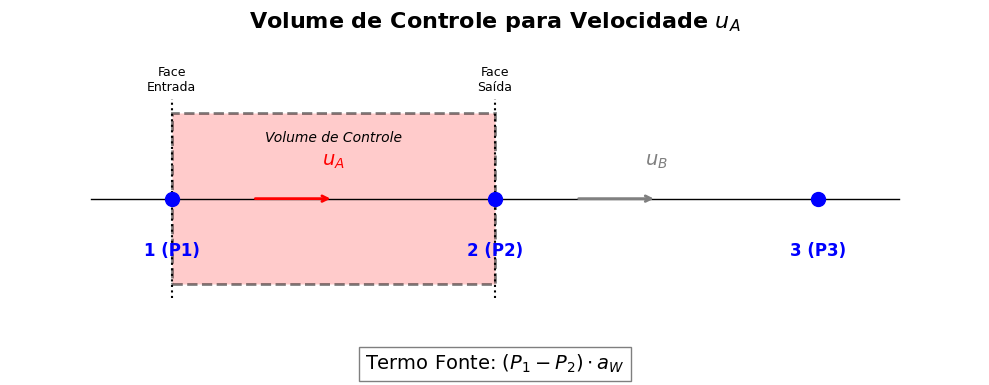

In [48]:
# --- Gerar as imagens ---
print("Gerando Volume de Controle para uA...")
draw_staggered_cv('A')


**Passo A: Integrar a Equação**

Integramos a equação governante sobre o volume de controle (de 1 a 2):

$$\int_{1}^{2} \frac{d}{dx}(\rho u A u) \, dx = \int_{1}^{2} - A \frac{dp}{dx} \, dx$$

**Passo B: O Termo Convectivo (Lado Esquerdo)**

A integral da derivada é simplesmente o valor na saída menos o valor na entrada (Teorema Fundamental do Cálculo):

$$[\rho u A u]_{\text{saída (face 2)}} - [\rho u A u]_{\text{entrada (face 1)}}$$

* Na face direita (em 2): O fluido sai com a velocidade que ele tem no centro do volume, ou seja, $u_A$.

* Na face esquerda (em 1): O fluido entra vindo do reservatório.

A simplificação do problema assume que o momentum que entra pela fronteira 1 é desprezível. Escrevendo a expressão em função da vazão mássica $F = \rho u A$.

$$\text{Termo Convectivo} \approx F_A u_A - F_{in} u_{in}$$

Como assumimos $u_{in} \approx 0$ (ou que não há fluxo de momentum vindo de trás da fronteira para esta equação simplificada):

$$\text{Termo Convectivo} \approx F_A u_A$$

Onde $F_A = \rho u_A A_A$ (Vazão mássica no local).

**Passo C: O Termo de Pressão (Lado Direito)**

Assumindo que a área $A$ é constante dentro desse pequeno volume (usamos a área $A_A$):

$$- A_A \int_{1}^{2} \frac{dp}{dx} \, dx = - A_A (p_2 - p_1) = A_A(p_1 - p_2)$$

**Passo D: Equação Final para $u_A$**

Igualando os dois lados:

$$F_A u_A = A_A(p_1 - p_2)$$

No formato de coeficientes ($a_P u_P = \text{Fonte}$):

$$\boxed{a_A u_A = (p_1 - p_2)A_A}$$

* Aqui, $a_A = F_A = \rho u_A A_A$.

* Não há vizinhos ($a_{nb}$) influenciando $u_A$ porque ele está na fronteira de entrada.

### 2.2 Discretização para a Velocidade $u_B$

O volume de controle para $u_B$ é centrado em B. Ele vai do nó de pressão 2 até o nó de pressão 3.


Gerando Volume de Controle para uB...


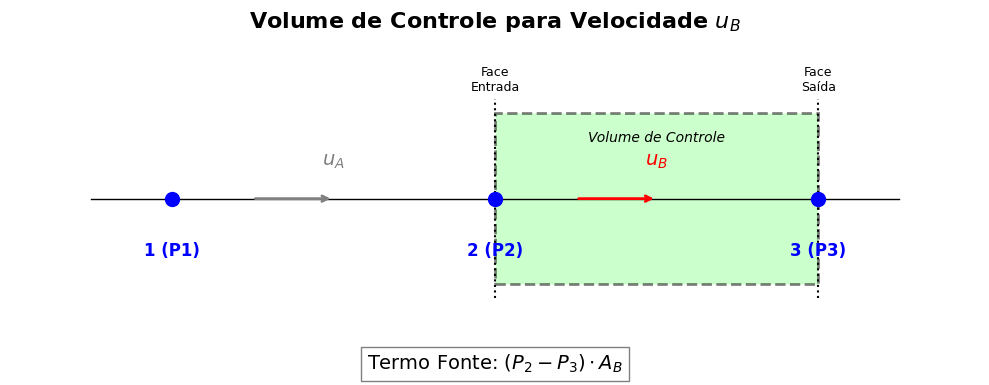

In [49]:
print("\nGerando Volume de Controle para uB...")
draw_staggered_cv('B')

**Passo A: Integrar**

$$\int_{2}^{3} \frac{d}{dx}(\rho u A u) \, dx = \int_{2}^{3} - A \frac{dp}{dx} \, dx$$

**Passo B: O Termo Convectivo (Lado Esquerdo)**

$$[\rho u A u]_{\text{saída (face 3)}} - [\rho u A u]_{\text{entrada (face 2)}}$$



1. **Saída (Face direita, em 3):** O fluido sai do volume B. A velocidade transportada é a própria $u_B$.

    * Fluxo de saída: $F_B u_B$ (onde $F_B = \rho u_B A_B$).


2. Entrada (Face esquerda, em 2): O fluido entra no volume B vindo do volume A.

    * Fluxo de entrada: $F_A u_A$ (Pela continuidade, $F_{entrada\_em\_B} = F_{saída\_de\_A}$).


Resultado do termo convectivo:

$$F_B u_B - F_A u_A$$

**Passo C: O Termo de Pressão (Lado Direito)**

Integrando o gradiente de pressão entre 2 e 3 com área $A_B$:

$$- A_B (p_3 - p_2) = A_B(p_2 - p_3)$$

**Passo D: Equação Final para $u_B$**

Igualando os lados:

$$F_B u_B - F_A u_A = A_B(p_2 - p_3)$$

Agora, isolamos $u_B$ (que é a nossa incógnita $u_P$ deste volume) e jogamos o vizinho para o outro lado:

$$F_B u_B = F_A u_A + A_B(p_2 - p_3)$$

No formato de coeficientes ($a_P u_P = a_W u_W + b$):

$$\boxed{a_B u_B = a_W u_A + (p_2 - p_3)A_B}$$

Onde:

* $a_B = F_B$ (Fluxo que sai, coeficiente central).

* $a_W = F_A$ (Fluxo que entra vindo do vizinho West/Oeste).

* $A_B =$ área em B

## 3. A Relaxação da Equação de Momentum (Passo de Predição)

A solução direta das equações de momentum discretizadas pode levar à divergência numérica devido à não-linearidade e ao forte acoplamento entre pressão e velocidade. Para estabilizar o processo iterativo, introduzimos o fator de sub-relaxação $\alpha_u$ (onde $0 < \alpha_u \leq 1$).

A sub-relaxação modifica a equação original $a_P u_P = \sum a_{nb} u_{nb} + b$ para aumentar a dominância da diagonal principal e introduzir uma "inércia" baseada no valor da iteração anterior ($u_P^{(old)}$).

A equação relaxada que será resolvida computacionalmente para obter o campo de velocidade predito ($u^*$) é dada por:

$$\frac{a_P}{\alpha_u} u_P^* = \sum a_{nb} u_{nb}^* + b + \left[ (1 - \alpha_u) \frac{a_P}{\alpha_u} u_P^{(old)} \right]$$

### 3.1 Definição dos Coeficientes Relaxados

Para implementação no código, definimos os novos coeficientes "relaxados" ($a^{relax}$) e as novas fontes ($b^{relax}$).

Para o Volume de Controle A ($u_A$):

$$a_A^{relax} = \frac{F_A}{\alpha_u}$$
$$b_A^{relax} = \underbrace{(p_1 - p_2^*) A_A}_{\text{Fonte Física}} + \underbrace{(1 - \alpha_u) a_A^{relax} u_A^{(old)}}_{\text{Termo de Relaxação}}$$

A velocidade predita é calculada como:

$$u_A^* = \frac{b_A^{relax}}{a_A^{relax}}$$

Para o Volume de Controle B ($u_B$):

$$a_B^{relax} = \frac{F_B}{\alpha_u}$$
$$b_B^{relax} = \underbrace{(p_2^* - p_3) A_B}_{\text{Fonte Física}} + \underbrace{(1 - \alpha_u) a_B^{relax} u_B^{(old)}}_{\text{Termo de Relaxação}}$$

A velocidade predita é calculada como (considerando o vizinho $a_W = F_A$):

$$u_B^* = \frac{a_W u_A^* + b_B^{relax}}{a_B^{relax}}$$

## 4. Equação de Correção de Pressão ($p'$)

O campo de velocidade $u^*$ obtido na etapa anterior satisfaz a equação de momentum, mas não necessariamente a equação da continuidade (conservação de massa). 

Para corrigir isso, propomos correções para a pressão ($p'$) e velocidade ($u'$):$$p = p^* + p'$$$$u = u^* + u'$$

As correções de velocidade são relacionadas ao gradiente da correção de pressão através dos coeficientes $d$.

### 4.1 Coeficientes de Ligação Velocidade-Pressão ($d$)

É fundamental notar que, para manter a consistência com as equações de momentum sub-relaxadas resolvidas no passo anterior, o cálculo de $d$ deve utilizar os coeficientes já relaxados ($a_P^{relax}$).

A definição de $d$ varia conforme o algoritmo:

* Algoritmos SIMPLE:

$$d_A = \frac{A_A}{a_A^{relax}} \quad \text{e} \quad d_B = \frac{A_B}{a_B^{relax}}$$

* Algoritmo SIMPLEC:

O SIMPLEC aproxima os termos vizinhos para acelerar a convergência, subtraindo-os do denominador:

$$d_A = \frac{A_A}{a_A^{relax}} \quad (\text{Sem vizinhos } u)$$

$$d_B = \frac{A_B}{a_B^{relax} - a_W}$$

### 4.2 Equação de Conservação de Massa

A equação de correção de pressão é obtida substituindo as equações de correção de velocidade na equação da continuidade discretizada:

$$\dot{m}_{saida} - \dot{m}_{entrada} = 0 \implies (\rho A_B u_B) - (\rho A_A u_A) = 0$$

Substituindo $u = u^* + u'$ e sabendo que $u' = -d \Delta p'$:

* $u_A = u_A^* + d_A (p'_1 - p'_2)$

* $u_B = u_B^* + d_B (p'_2 - p'_3)$

Como $p_1$ e $p_3$ são fronteiras de pressão prescrita, suas correções são nulas ($p'_1 = 0, p'_3 = 0$). Logo:

* $u_A = u_A^* - d_A p'_2$

* $u_B = u_B^* + d_B p'_2$

Substituindo na continuidade, chegamos à equação linear para $p'_2$:

$$a_P^{pp} p'_2 = b_{massa}$$

Onde os coeficientes são:

$$a_P^{pp} = (\rho A_A d_A) + (\rho A_B d_B)$$

$$b_{massa} = \rho A_A u_A^* - \rho A_B u_B^*$$

O termo $b_{massa}$ representa o Resíduo de Massa. O objetivo do processo iterativo é zerar este termo. No presente trabalho, consideramos que a convergência é alcançada quando $b_{massa}<10^{-6}$

## 5. Atualização dos campos de velocidade e pressão

Os campos de velocidade e pressão corrigidos são calculados da seguinte forma:

* Velocidades:

$$u_A^{novo} = u_A^* - d_A p_2'$$

$$u_B^{novo} = u_B^* + d_B p_2'$$

* Pressão (Com sub-relaxação $\alpha_p$):

$$p_2^{novo} = p_2^* + \alpha_p p_2'$$

## 6. O Algoritmo SIMPLER (SIMPLE Revised)

O algoritmo SIMPLER (SIMPLE Revised) foi proposto por Patankar (1980) para remediar uma deficiência do método SIMPLE: a de que a equação de correção de pressão ($p'$), embora ótima para corrigir velocidades, fornece um campo de pressão muitas vezes impreciso ou que requer pesada sub-relaxação.

No SIMPLER, o campo de pressão é calculado antes da resolução das equações de momentum, utilizando um campo de "pseudo-velocidades". 

A sequência de cálculo é alterada para:

1. Calcular Pseudo-Velocidades ($\hat{u}$).

2. Calcular o Campo de Pressão ($p$) resolvendo a Equação de Pressão.
    
3. Resolver as Equações de Momentum (obtendo $u^*$).
    
4. Resolver a Equação de Correção de Pressão ($p'$).
   
5. Corrigir apenas as velocidades ($u = u^* + u'$). 
  
6. Não se corrige a pressão com $p'$ no SIMPLER
    
### 6.1 Pseudo-Velocidades ($\hat{u}$)

As pseudo-velocidades são definidas removendo o gradiente de pressão das equações de momentum discretizadas. Usamos os coeficientes relaxados ($a_P^{relax}$) para manter consistência:

$$\hat{u}_P = \frac{\sum a_{nb} u_{nb} + b_{sem\_pressao}}{a_P^{relax}}$$

* Para o Volume de Controle A:Como não há vizinho a montante de velocidade e a pressão é removida:

$$  \hat{u}_A = \frac{0}{a_A^{relax}} = 0 \quad (\text{Pois } a_W=0 \text{ e } b_{sem\_p}=0)$$

(Nota: Isso ocorre especificamente neste problema 1D sem fontes extras. Em problemas gerais, $\hat{u}$ não seria zero).

* Para o Volume de Controle B:

$$  \hat{u}_B = \frac{a_W u_A + 0}{a_B^{relax}} = \frac{F_A u_A}{a_B^{relax}}$$

(Aqui usamos o $u_A$ da iteração anterior).

### 6.2 A Equação de Pressão

A equação para obter o campo de pressão real ($p$) é derivada substituindo as velocidades na equação da continuidade por uma expressão que envolve $\hat{u}$ e o gradiente de pressão:

$$u_P = \hat{u}_P - d_P \Delta p$$

Substituindo na continuidade, obtemos uma equação idêntica à de $p'$, mas com um termo fonte diferente:

$$a_P^{press} p_2 = b_{\hat{u}} + \text{Termos de Fronteira}$$

Onde os coeficientes $a_P^{press}$ e $d$ são os mesmos usados no SIMPLE:

$$a_P^{press} = (\rho A_A d_A) + (\rho A_B d_B)$$

E a fonte $b_{\hat{u}}$ é o "resíduo de massa" calculado com as pseudo-velocidades:

$$b_{\hat{u}} = (\rho A_A \hat{u}_A) - (\rho A_B \hat{u}_B)$$

Atenção às Condições de Contorno:Como $p_1$ e $p_3$ são valores fixos (conhecidos), eles não são incógnitas. Eles passam para o lado direito da equação (fonte):

$$a_P^{press} p_2 = b_{\hat{u}} + (\rho A_A d_A p_1) + (\rho A_B d_B p_3)$$

Logo:

$$p_2 = \frac{b_{\hat{u}} + \rho A_A d_A p_1 + \rho A_B d_B p_3}{a_P^{press}}$$

### 6.3 O Papel do $p'$ no SIMPLER

Após obter $p_2$, usamos esse valor para calcular as fontes do momentum e encontrar $u^*$. Em seguida, resolvemos a equação de $p'$ (exatamente como no SIMPLE, Seção 4).Porém, na etapa de correção final:

* Velocidades: São corrigidas usando $p'$ ($u = u^* - d \Delta p'$).

* Pressão: O valor de $p_2$ calculado na etapa 6.2 já é mantido. 

Não somamos $p'$ a ele. O campo $p'$ serve apenas para projetar a velocidade num campo conservativo.

In [50]:
def solve_nozzle_unified(algo='SIMPLE', alpha_u=0.5, alpha_p=0.8, max_iter=100, tol=1e-6, verbose=True):
    """
    Solver Unificado para SIMPLE, SIMPLEC e SIMPLER
    Problema: Escoamento 1D em Bocal (Patankar Exemplo 6.5)
    """
    
    # --- 1. Definição do Problema (Parâmetros Físicos e Geométricos) ---
    rho = 1.0
    AA = 3.0
    AB = 1.0
    p1 = 28.0  # Pressão Entrada (Fixa)
    p3 = 0.0   # Pressão Saída (Fixa)

    # Condições Iniciais (Chute inicial)
    uA_star = 5.0 / 3.0  # uA arbitrário
    uB_star = 5.0        # uB arbitrário
    p2_star = 25.0       # p2 (incógnita) arbitrário

    history = []

    if verbose:    
        print(f"\n>>> Iniciando Algoritmo: {algo} | alpha_u={alpha_u} | alpha_p={alpha_p}")
        print(f"{'Iter':<5} {'uA':<12} {'uB':<12} {'p2':<12} {'Resíduo Mass':<12}")

    for it in range(1, max_iter + 1):
        
        # Guardar valores da iteração anterior ("old")
        uA_old = uA_star
        uB_old = uB_star
        p2_old = p2_star # Apenas para referência no SIMPLER

        # ------------------------------------------------------------------
        # SEÇÃO 2: Discretização Básica (Cálculo dos Fluxos F)
        # ------------------------------------------------------------------
        FA = rho * uA_star * AA
        FB = rho * uB_star * AB
        
        # Coeficientes Físicos de Momentum (aP_fisico = F)
        aA_phys = FA
        aB_phys = FB
        aW_phys = FA  # Coeficiente do vizinho para o volume B (vem de A)

        # ------------------------------------------------------------------
        # SEÇÃO 3: Relaxação da Equação de Momentum (Preparação)
        # ------------------------------------------------------------------
        # Coeficientes Relaxados (usados em todos os algoritmos)
        aA_relax = aA_phys / alpha_u
        aB_relax = aB_phys / alpha_u

        # ------------------------------------------------------------------
        # SEÇÃO 6: O Algoritmo SIMPLER (Bloco Condicional)
        # ------------------------------------------------------------------
        # No SIMPLER, calculamos a pressão correta ANTES do momentum
        if algo == 'SIMPLER':
            # 6.1 Pseudo-velocidades (u_hat)
            # u_hat_A = 0 pois não tem vizinho a montante resolvido
            u_hat_A = 0.0 
            # u_hat_B considera o vizinho uA (mas sem gradiente de pressão)
            u_hat_B = (aW_phys * uA_star) / aB_relax
            
            # 6.2 Equação de Pressão (Coeficientes d são os mesmos)
            d_hat_A = AA / aA_relax
            d_hat_B = AB / aB_relax
            
            aP_press = (rho * AA * d_hat_A) + (rho * AB * d_hat_B)
            
            # Fonte b_hat baseada nas pseudo-velocidades + Termos de contorno (p1, p3)
            b_hat = (rho * AA * u_hat_A) - (rho * AB * u_hat_B)
            b_hat_total = b_hat + (rho * AA * d_hat_A * p1) + (rho * AB * d_hat_B * p3)
            
            # Resolver Pressão
            p2_simpler = b_hat_total / aP_press
            
            # Atualizar p2_star para usar no Momentum logo abaixo
            p2_star = p2_simpler

        # ------------------------------------------------------------------
        # CONTINUAÇÃO SEÇÃO 3: Cálculo das Fontes e Solução Momentum (u*)
        # ------------------------------------------------------------------
        # Termos Fontes Relaxados (Gradiente de Pressão + Inércia)
        # Nota: p2_star aqui é o da iteração anterior (SIMPLE) ou o recém calculado (SIMPLER)
        
        # Fonte para A: (p1 - p2)*A + Termo Memória
        bA_relax = (p1 - p2_star) * AA + (1 - alpha_u) * aA_relax * uA_old
        
        # Fonte para B: (p2 - p3)*A + Termo Memória
        bB_relax = (p2_star - p3) * AB + (1 - alpha_u) * aB_relax * uB_old

        # Solução das Velocidades Preditas (u*)
        uA_star = bA_relax / aA_relax
        uB_star = (bB_relax + aW_phys * uA_star) / aB_relax # Gauss-Seidel: usa uA_star atual

        # ------------------------------------------------------------------
        # SEÇÃO 4: Equação de Correção de Pressão (p')
        # ------------------------------------------------------------------
        
        # 4.1 Coeficientes de Ligação (d)
        if algo == 'SIMPLEC':
            # SIMPLEC: Subtrai os vizinhos do denominador
            # Para A: não tem vizinho u resolvido influenciando, d mantem
            dA = AA / aA_relax
            # Para B: tem vizinho aW
            dB = (AB / FA) * (alpha_u / (1 - alpha_u))
        else:
            # SIMPLE e SIMPLER: d = A / a_relax
            dA = AA / aA_relax
            dB = AB / aB_relax

        # 4.2 Equação de Correção de Pressão (ap * p' = b_massa)
        aP_pp = (rho * AA * dA) + (rho * AB * dB)
        b_pp = (rho * AA * uA_star) - (rho * AB * uB_star) # Resíduo de Massa
        
        # Resolver p'
        p2_prime = b_pp / aP_pp

        # ------------------------------------------------------------------
        # SEÇÃO 5: Correção dos Campos
        # ------------------------------------------------------------------
        
        # Correção de Velocidade (Igual para todos)
        # u_new = u* - d * grad(p')
        uA_new = uA_star + dA * (p1 - p2_prime - p1) # p1'=0 -> -dA*(-p2') = +dA*p2' ??
        # Vamos pela fórmula: u' = -d * dp'. 
        # uA: grad = (p2'-p1') = p2'. Logo uA' = -dA * p2'? NÃO.
        # Equação A: F = (p1-p2). uA projeta para frente. uA' = dA(p1'-p2') = -dA*p2'
        uA_new = uA_star - dA * p2_prime
        
        # Equação B: F = (p2-p3). uB' = dB(p2'-p3') = dB*p2'
        uB_new = uB_star + dB * p2_prime

        # Correção de Pressão
        if algo == 'SIMPLER':
            # No SIMPLER, a pressão já foi calculada corretamente no início (6.2).
            # Não aplicamos p' na pressão, apenas na velocidade.
            p2_new = p2_star # O valor calculado no bloco SIMPLER
        else:
            # SIMPLE e SIMPLEC: p_new = p* + alpha_p * p'
            p2_new = p2_star + alpha_p * p2_prime

        # ------------------------------------------------------------------
        # Verificação de Convergência e Update Final
        # ------------------------------------------------------------------
        # Atualizar para a próxima iteração
        uA_star = uA_new
        uB_star = uB_new
        p2_star = p2_new
        
        history.append({'Iter': it, 'uA': uA_star, 'uB': uB_star, 'p2': p2_star, 'Res': abs(b_pp)})
        if verbose:
            print(f"{it:<5} {uA_star:<12.6f} {uB_star:<12.6f} {p2_star:<12.6f} {abs(b_pp):<12.3e}")

        if abs(b_pp) < tol:
            if verbose: print(f">>> Convergência alcançada em {it} iterações.")
            break
            
    return pd.DataFrame(history)

## 7. Resultados

### 7.1 Exemplo 4

Inicialmente, o problema foi simulado com os parâmetros de sub-relaxação apresentados nas notas de aula do Exemplo #4, a fim de verificar e comparar as tabelas de resultados. 

Verificou-se que as tabelas obtidas no presente trabalho apresentam valores praticamente iguais aos apresentados nas notas de aula:

* Utilizando o método SIMPLE com os fatores de sub-relaxação $\alpha_u = 0.5$ e $\alpha_p = 0.8$:


>>> Executando SIMPLE...

>>> Iniciando Algoritmo: SIMPLE | alpha_u=0.5 | alpha_p=0.8
Iter  uA           uB           p2           Resíduo Mass
1     1.933333     5.800000     24.466667    6.667e-01   
2     1.972874     5.918621     24.180800    3.080e-01   
3     1.989216     5.967649     24.070788    1.162e-01   
4     1.995738     5.987215     24.027814    4.501e-02   
5     1.998319     5.994958     24.010944    1.761e-02   
6     1.999338     5.998013     24.004308    6.918e-03   
7     1.999739     5.999217     24.001697    2.722e-03   
8     1.999897     5.999692     24.000668    1.071e-03   
9     1.999960     5.999879     24.000263    4.219e-04   
10    1.999984     5.999952     24.000104    1.661e-04   
11    1.999994     5.999981     24.000041    6.543e-05   
12    1.999998     5.999993     24.000016    2.577e-05   
13    1.999999     5.999997     24.000006    1.015e-05   
14    2.000000     5.999999     24.000002    3.996e-06   
15    2.000000     6.000000     24.000001  

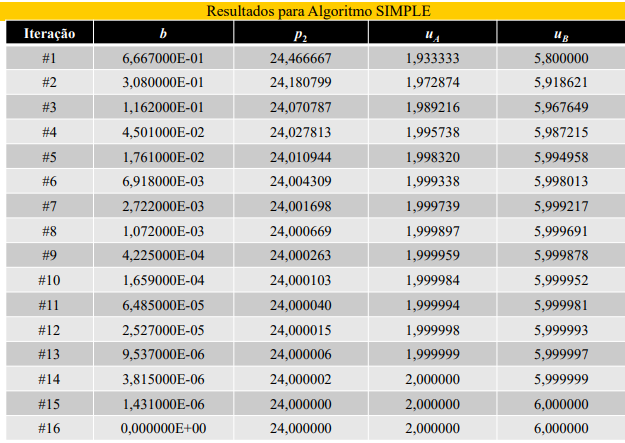

In [51]:
print("\n>>> Executando SIMPLE...")
df_simple = solve_nozzle_unified(algo='SIMPLE', alpha_u=0.5, alpha_p=0.8);

Image("tabela_SIMPLE.png", width=600)


* Utilizando o método SIMPLEC com os fatores de sub-relaxação $\alpha_u = 0.5$ e $\alpha_p = 1$:


>>> Executando SIMPLEC...

>>> Iniciando Algoritmo: SIMPLEC | alpha_u=0.5 | alpha_p=1
Iter  uA           uB           p2           Resíduo Mass
1     1.915152     5.745455     24.393939    6.667e-01   
2     1.966678     5.900035     24.134831    2.480e-01   
3     1.987909     5.963728     24.048667    8.032e-02   
4     1.995601     5.986803     24.017636    2.862e-02   
5     1.998400     5.995200     24.006405    1.032e-02   
6     1.999418     5.998255     24.002328    3.740e-03   
7     1.999788     5.999365     24.000846    1.359e-03   
8     1.999923     5.999769     24.000308    4.938e-04   
9     1.999972     5.999916     24.000112    1.795e-04   
10    1.999990     5.999969     24.000041    6.528e-05   
11    1.999996     5.999989     24.000015    2.374e-05   
12    1.999999     5.999996     24.000005    8.632e-06   
13    2.000000     5.999999     24.000002    3.139e-06   
14    2.000000     5.999999     24.000001    1.141e-06   
15    2.000000     6.000000     24.000000  

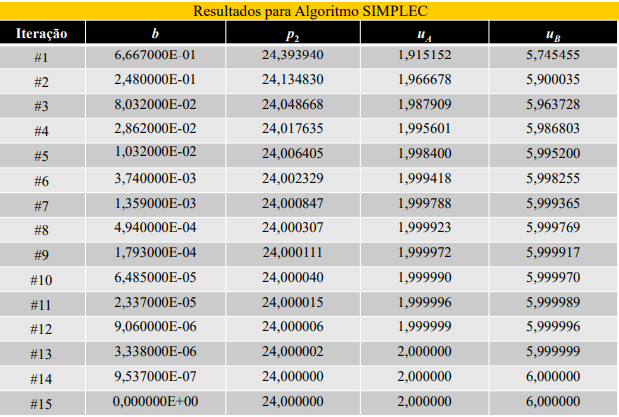

In [52]:
print("\n>>> Executando SIMPLEC...")
df_simplec = solve_nozzle_unified(algo='SIMPLEC', alpha_u=0.5, alpha_p=1);

Image("tabela_SIMPLEC.png", width=600)

* Utilizando o método SIMPLER com os fatores de sub-relaxação $\alpha_u = 0.7$


>>> Executando SIMPLER...

>>> Iniciando Algoritmo: SIMPLER | alpha_u=0.7 | alpha_p=1.0
Iter  uA           uB           p2           Resíduo Mass
1     2.101460     6.304380     24.366667    2.515e-01   
2     1.984053     5.952159     23.875160    6.792e-02   
3     2.003039     6.009117     24.019060    1.098e-02   
4     1.999438     5.998314     23.996351    2.083e-03   
5     2.000104     6.000313     24.000674    3.855e-04   
6     1.999981     5.999942     23.999875    7.168e-05   
7     2.000004     6.000011     24.000023    1.332e-05   
8     1.999999     5.999998     23.999996    2.474e-06   
9     2.000000     6.000000     24.000001    4.597e-07   
10    2.000000     6.000000     24.000000    8.542e-08   
>>> Convergência alcançada em 10 iterações.


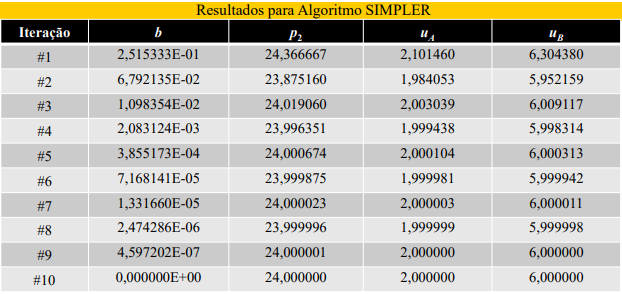

In [53]:
print("\n>>> Executando SIMPLER...")
df_simpler = solve_nozzle_unified(algo='SIMPLER', alpha_u=0.7, alpha_p=1.0, tol=1e-7);

Image("tabela_SIMPLER.png", width=600)

### 7.2 Teste de sensibilidade aos fatores de sub-relaxação

A fim de investigar a influência dos fatores de sub-relaxação em cada método de solução, novas simulações foram realizadas considerando fatores baixos, altos e intermediários:

In [54]:
# --- Definição dos Cenários de Teste ---
test_cases = [
    # Caso 1: Base 
    {"name": "Base", "alpha_u": 0.5, "alpha_p": 0.5},
    
    # Caso 2: Alta Relaxação (Fatores baixos)
    {"name": "Relaxado", "alpha_u": 0.1, "alpha_p": 0.1},
    
    # Caso 3: Fatores altos 
    {"name": "Não Relaxado", "alpha_u": 0.99, "alpha_p": 0.99}
]

algorithms = ["SIMPLE", "SIMPLEC", "SIMPLER"]
results_summary = []  # Para a tabela
plots_data = {}       # Para os gráficos

print("Rodando simulações comparativas...")

for case in test_cases:
    case_name = case["name"]
    plots_data[case_name] = {}
    
    for algo in algorithms:
        # Rodar simulação (verbose=False para não encher a tela)
        df = solve_nozzle_unified(
            algo=algo, 
            alpha_u=case["alpha_u"], 
            alpha_p=case["alpha_p"],
            max_iter=100, # Limite para não travar se não convergir
            verbose=False, 
        )
        
        # Guardar dados para plotagem
        plots_data[case_name][algo] = df
        
        # --- NOVO: Coletar os dados da última iteração ---
        last_row = df.iloc[-1]
        converged = last_row['Res'] < 1e-6
        
        results_summary.append({
            "Cenário": case_name,
            "Algoritmo": algo,
            "Alpha_u": case["alpha_u"],
            "Alpha_p": case["alpha_p"],
            "Iterações": int(last_row['Iter']) if converged else "Não Convergiu",
            "Resíduo Final": last_row['Res'],
            "uA Final": last_row['uA'],
            "uB Final": last_row['uB'],
            "p2 Final": last_row['p2']
        })

print("Simulações concluídas!")

Rodando simulações comparativas...
Simulações concluídas!


In [55]:
# --- 1. Tabela de Resultados ---
# --- Exibição da Tabela Rica ---
df_results = pd.DataFrame(results_summary)

# Reordenar colunas para melhor leitura
cols = ["Cenário", "Algoritmo", "Alpha_u", "Alpha_p", "Iterações", "uA Final", "uB Final", "p2 Final", "Resíduo Final"]
df_results = df_results[cols]

print("\n### Tabela Resumo: Convergência e Solução Física ###")
# Formatando para ficar bonito (3 casas decimais para física, notação científica para resíduo)
display(df_results.style.format({
    "uA Final": "{:.4f}",
    "uB Final": "{:.4f}",
    "p2 Final": "{:.4f}",
    "Resíduo Final": "{:.1e}"
}))



### Tabela Resumo: Convergência e Solução Física ###


,Cenário,Algoritmo,Alpha_u,Alpha_p,Iterações,uA Final,uB Final,p2 Final,Resíduo Final
0,Base,SIMPLE,0.500000,0.500000,28,2.0000,6.0000,24.0000,7.6e-07
1,Base,SIMPLEC,0.500000,0.500000,32,2.0000,6.0000,24.0000,8.5e-07
2,Base,SIMPLER,0.500000,0.500000,8,2.0000,6.0000,24.0000,7.0e-07
3,Relaxado,SIMPLE,0.100000,0.100000,Não Convergiu,2.0000,6.0000,24.0001,1.4e-05
4,Relaxado,SIMPLEC,0.100000,0.100000,Não Convergiu,2.0000,6.0000,24.0001,1.6e-05
5,Relaxado,SIMPLER,0.100000,0.100000,55,1.9999,5.9998,24.0001,9.4e-07
6,Não Relaxado,SIMPLE,0.990000,0.990000,Não Convergiu,1.9799,5.9396,23.9998,6.3e-04
7,Não Relaxado,SIMPLEC,0.990000,0.990000,Não Convergiu,1.9883,5.9650,24.0014,2.0e-03
8,Não Relaxado,SIMPLER,0.990000,0.990000,60,2.0000,6.0000,24.0000,8.1e-07



É importante ressaltar que o critério de convergência adotado foi rigoroso, exigindo um resíduo de massa inferior a $1 \times 10^{-6}$, com um limite máximo de 100 iterações. Conforme observado na tabela, as simulações com baixos fatores de relaxação ($\alpha = 0.1$) para os métodos SIMPLE e SIMPLEC foram classificadas como 'Não Convergiu'. Isso ocorre não por instabilidade, mas devido ao excessivo amortecimento numérico que torna a redução do resíduo extremamente lenta. 

Nota-se que, apesar de o resíduo final estar na ordem de $10^{-5}$ (próximo da tolerância), os campos de velocidade e pressão obtidos já apresentavam valores fisicamente satisfatórios e idênticos aos casos convergidos. Testes estendidos confirmaram que, ao aumentar o número de iterações permitidas, essas simulações atingem o critério de convergência estabelecido.

A figura abaixo apresenta a evolução do resíduo de massa (em escala logarítmica) ao longo das iterações para os três algoritmos, submetidos a diferentes fatores de relaxação.

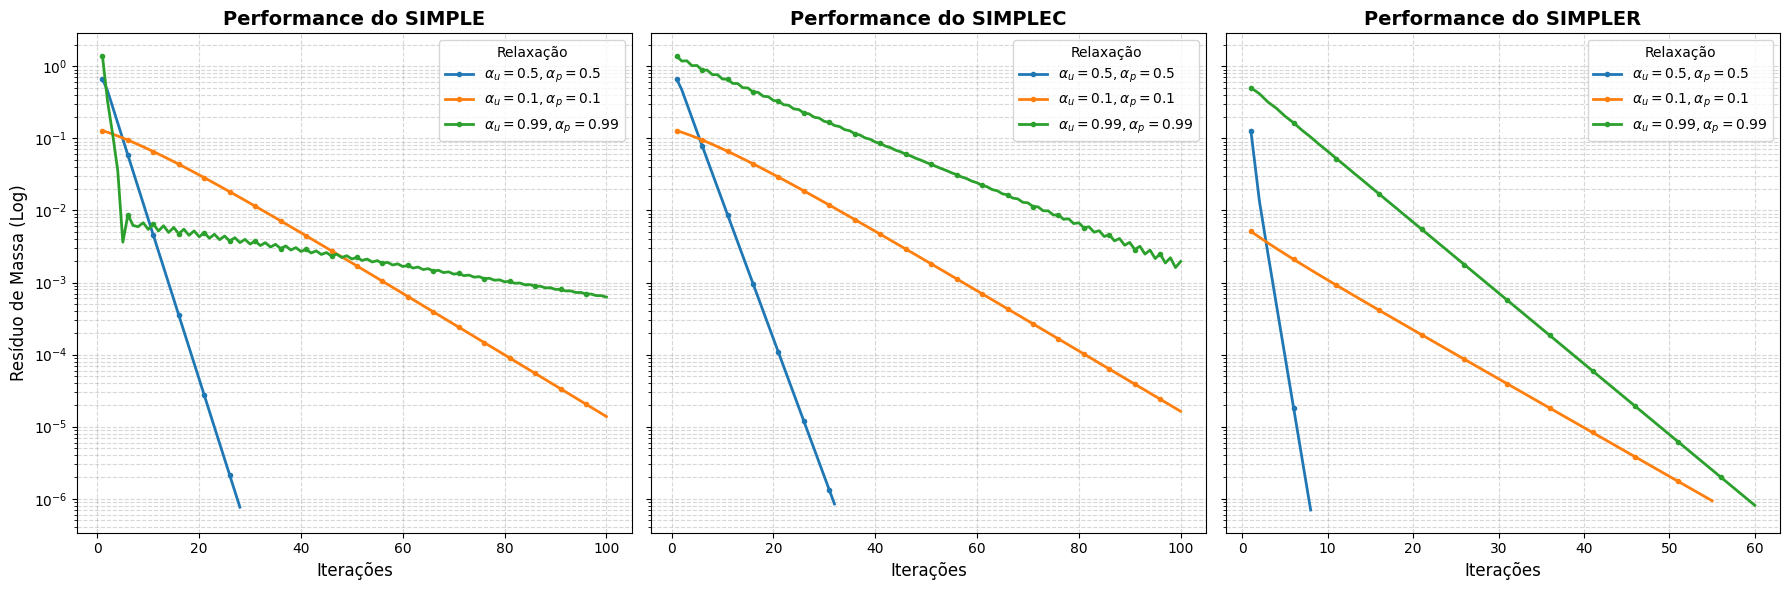

In [56]:
# --- GERAÇÃO DOS GRÁFICOS POR ALGORITMO ---

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop Externo: Algoritmos (Um gráfico para cada)
for i, algo in enumerate(algorithms):
    ax = axes[i]
    
    # Loop Interno: Casos de Relaxação (Curvas dentro do gráfico)
    for case in test_cases:
        case_name = case["name"]
        
        # Recupera os dados
        df = plots_data[case_name][algo]
        
        # Define o rótulo da legenda com os alphas
        label_text = f"$\\alpha_u={case['alpha_u']}, \\alpha_p={case['alpha_p']}$"
        
        # Plota (Escala logarítmica no Y é essencial para ver convergência)
        ax.semilogy(df['Iter'], df['Res'], label=label_text, linewidth=2, marker='o', markersize=3, markevery=5)

    # Estilização do Gráfico
    ax.set_title(f"Performance do {algo}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Iterações", fontsize=12)
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend(title="Relaxação", fontsize=10)
    
    # Eixo Y apenas no primeiro gráfico para ficar limpo
    if i == 0:
        ax.set_ylabel("Resíduo de Massa (Log)", fontsize=12)

plt.tight_layout()
plt.show()

Observa-se que a inclinação das curvas representa a taxa de convergência: quanto mais íngreme, mais rápida é a solução.

No gráfico do SIMPLE, nota-se claramente a instabilidade causada pela falta de sub-relaxação ($\alpha=0.99$, linha verde), onde o resíduo oscila inicialmente e estabiliza em um patamar alto, impedindo a convergência rigorosa.

No gráfico do SIMPLER, destaca-se a robustez do método. Mesmo nos casos extremos ($\alpha=0.1$ ou $\alpha=0.99$), o algoritmo manteve uma taxa de decaimento do resíduo constante, atingindo a convergência em todos os cenários testados dentro do limite de iterações.

O caso base ($\alpha=0.5$, linha azul) confirma a superioridade do SIMPLER, que atinge a convergência em menos de 10 iterações, enquanto SIMPLE e SIMPLEC exigem cerca de 30 iterações para o mesmo resultado.Esses comportamentos visuais corroboram os dados quantitativos apresentados na Tabela de Resultados e fundamentam as conclusões a seguir.

## 8. Conclusões

O presente trabalho implementou e comparou os algoritmos SIMPLE, SIMPLEC e SIMPLER aplicados a um problema de escoamento unidimensional em bocal. A análise dos resultados numéricos e do comportamento de convergência permite tecer as seguintes conclusões:

* Eficiência Computacional (Caso Base):Sob condições idênticas de relaxação ($\alpha = 0.5$), o algoritmo SIMPLER mostrou-se superior, atingindo o critério de convergência ($R < 10^{-6}$) em apenas 8 iterações, contra 28 do SIMPLE e 32 do SIMPLEC. Isso comprova que o cálculo explícito do campo de pressão (passo extra do SIMPLER) acelera drasticamente a resolução do acoplamento pressão-velocidade.

* Robustez e Estabilidade:O SIMPLER foi o único algoritmo capaz de convergir em todos os cenários de teste, incluindo o caso crítico sem sub-relaxação ($\alpha=0.99$), onde convergiu em 60 iterações. Em contraste, o SIMPLE demonstrou instabilidade com fatores altos, falhando em convergir e apresentando oscilações no resíduo.

* Análise de "Falsa" Não-Convergência (Fatores Baixos): Nos casos fortemente sub-relaxados ($\alpha=0.1$), os métodos SIMPLE e SIMPLEC foram classificados como não convergidos devido ao limite de 100 iterações. Entretanto, a análise dos dados finais revela que a solução física foi alcançada com precisão: as velocidades finais ($u_A \approx 2.0$, $u_B \approx 6.0$) e a pressão ($p_2 \approx 24.0$) são idênticas às dos casos convergidos. O resíduo estagnou na ordem de $10^{-5}$ apenas devido ao excessivo amortecimento numérico, e não por falha do algoritmo.

* Consistência da Solução Física:Independentemente do algoritmo ou do fator de relaxação utilizado, todas as simulações que estabilizaram conduziram aos mesmos valores finais de velocidade e pressão. Isso valida a implementação numérica, demonstrando que as diferenças entre os métodos (SIMPLE/C/R) são puramente algorítmicas (velocidade e caminho para a solução) e não alteram o resultado físico final do problema.

Em suma, para este problema 1D, o SIMPLER apresenta a melhor relação custo-benefício, pois a redução no número de iterações compensa o esforço computacional adicional de resolver uma equação de pressão extra a cada passo.